# Vodafone challenge

In [34]:
# Import useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.simplefilter('ignore')

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold

# Random seed for reproducibility
seed = 202
np.random.seed(seed)

In [35]:
# Import the train set and test set
train_data = pd.read_csv("final_train.csv", delimiter=",")
test_data = pd.read_csv("final_test.csv", delimiter=",")

In [36]:
#train_data = train_data.drop('DataArpu', axis=1)
train_data = train_data.drop('ID', axis=1)
# Sort the dataset
train_data = train_data.iloc[np.random.permutation(len(train_data))]
train_data = train_data.reset_index(drop=True)

In [37]:
array = np.asarray(train_data)

X = array[:,0:train_data.shape[1]-1]
X = np.asarray(X)
Y = array[:,train_data.shape[1]-1]
Y = np.asarray(Y)

## select the number of features

In [38]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# It must be at most max_feature_number - 1
feature_number = 26

chi2_test = SelectKBest(score_func=chi2, k=feature_number)
fit = chi2_test.fit(X,Y)

In [39]:
def features_labels_split(data):
    
    features = data[train_data.columns[chi2_test.get_support(indices=True)]]
    labels = data['Product']
    return features, labels

In [40]:
def train_test_validation_split(features, labels, val_samples, test_samples):

    features = np.asarray(features)
    labels =np.asarray(labels)
    
    X_test = features[0:test_samples]
    y_test = labels[0:test_samples]

    X_val = features[test_samples:test_samples + val_samples]
    y_val = labels[test_samples:test_samples + val_samples]

    X_train = features[test_samples + val_samples:]
    y_train = labels[test_samples + val_samples:]

    return X_train, X_test, X_val, y_train, y_test, y_val

## data creation

In [41]:
train_feat, train_label = features_labels_split(train_data)

num_val_samples = 0
num_test_samples = 950
X_train, X_test, X_val, y_train, y_test, y_val = train_test_validation_split(train_feat, train_label, num_val_samples, num_test_samples)

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Build the default models to select the best one  
# The commented classifiers are weak
tuned_rf = RandomForestClassifier(n_jobs=-1, random_state=seed)
base_rf = RandomForestClassifier(n_jobs=-1, random_state=seed)


# Append all the models into an array
models = []
models.append(('tunedRF', tuned_rf))
models.append(('baseRF', base_rf))

## training comparison

tunedRF: 0.571 (0.025)
baseRF: 0.571 (0.025)


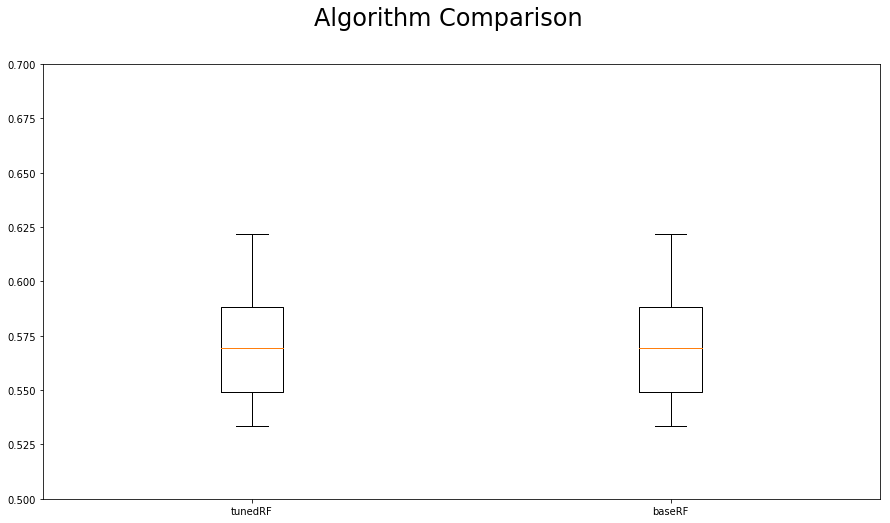

In [43]:
from sklearn.model_selection import cross_val_score

# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_micro', n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=(15, 8))
fig.suptitle('Algorithm Comparison', fontsize=24)
ax = fig.add_subplot(1,1,1)
plt.boxplot(results)
plt.ylim([0.50,0.70])
ax.set_xticklabels(names)
plt.show()

## Computing best features
Before starting the tuning phase, we chose the best number of features for each classifier and we plotted the best (mean) performances that we could observe performing a complete exploration of all the possibilities.

Model: RF, Avg_Score: 0.571, Num_Feat: 25


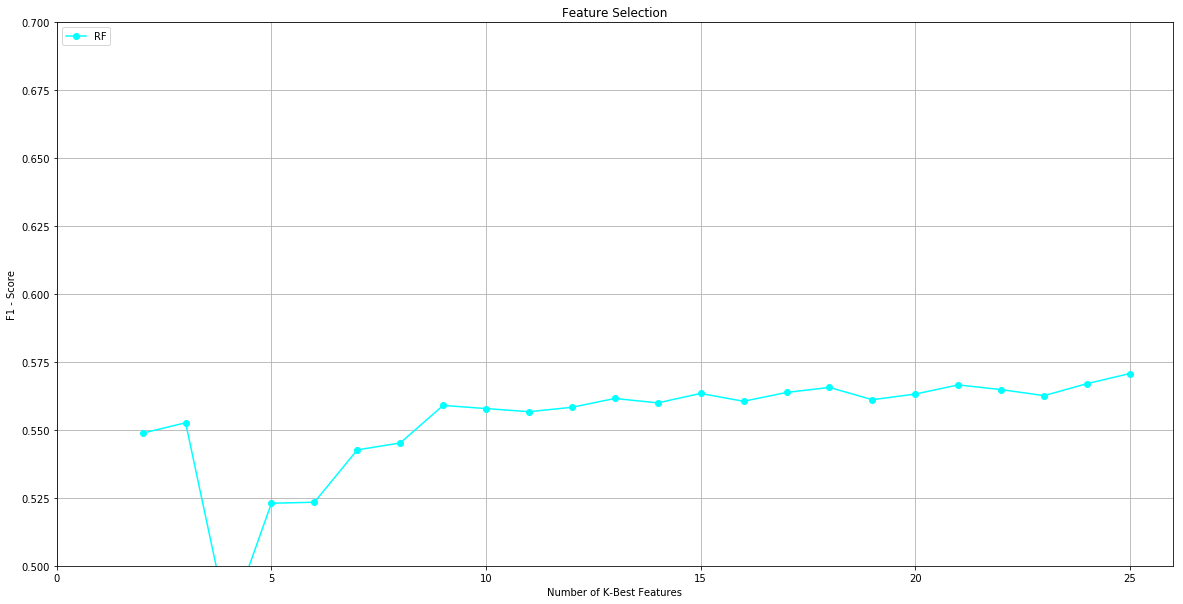

In [44]:
models = []
models.append(('RF', tuned_rf, 'Cyan'))


feat_range = X_train.shape[1]

n = ['RF']
n_number = np.arange(2,feat_range,1)
# Transforming the lists into array for plotting
plt.figure(figsize=(20, 10))
plt.title('Feature Selection')
plt.xlabel("Number of K-Best Features")
plt.ylabel("F1 - Score")
plt.grid()

num_feat_arr = []
for name, model, c in models:
    
    scores = [0, 0]
    results = []

    for n in range(2,feat_range):

        selection = SelectKBest(k=n).fit(X_train,y_train)
        X_k = selection.transform(X_train)
        
        
        # Feature Scaling
        from sklearn.preprocessing import StandardScaler
        sc = StandardScaler()
        X_k = sc.fit_transform(X_k)
        
        score = cross_val_score(estimator = model, X = X_k, y = y_train, cv = 10, scoring='f1_micro')
        f1 = score.mean()
        
        results.append(f1)
        
        std = score.std()
        if scores[0] < f1:
            scores = [f1, n]
  
    plt.plot(n_number, results, 'o-', color=c, label=name)
    
    num_feat_arr.append(scores[1])
    max_avg = np.average(scores)
    
    print("Model: %s, Avg_Score: %.3f, Num_Feat: %d" % (name, scores[0], scores[1]))  


plt.axis([0, feat_range , 0.50, 0.70])
plt.legend(bbox_to_anchor=(0, 1), loc='upper left', ncol=1)
plt.show()

## Random Forest hyperparameters tuning

In [50]:
from sklearn.model_selection import GridSearchCV

classifier = RandomForestClassifier(    
    n_jobs=-1, 
    n_estimators = 500,
    min_samples_leaf = 1,
    random_state=seed
)

max_features = ('auto','log2',0.2,0.4)
# n_estimators = np.arange(100,1000,100)
# n_estimators = (100,200,500,1000)
# n_estimators = np.arange(300,800,50)
# min_sample_leaf = np.arange(10,110,20)
# min_samples_leaf = (1,5,10,20,40,70,100)
# min_samples_leaf = np.arange (1,5,1)

parameters = [{
    'max_features':max_features,
#     'n_estimators':n_estimators,
#     'min_samples_leaf':min_samples_leaf
               }]

grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring='f1_micro',
                           cv = 10,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train, y_train)
best_f1 = grid_search.best_score_
best_parameters = grid_search.best_params_
print(best_f1)
print(best_parameters)

0.597771846350238
{'max_features': 'auto'}


In [28]:
# Test Performance

test_model = XGBClassifier(n_jobs=-1)
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)
# F1
print("F1 score on unseen data: %.3f" % f1_score(y_test, y_pred, average='micro'))

F1 score on unseen data: 0.608


c:\users\eugen\anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [40]:
X_pred = test_data[train_data.columns[chi2_test.get_support(indices=True)]]

In [41]:
classifier = RandomForestClassifier(n_estimators=400)
classifier.fit(train_feat, train_label)
y_pred = classifier.predict(X_pred)

In [42]:
submit = test_data['ID']
submit = pd.DataFrame({'ID': submit})

pred = y_pred
pred = pd.DataFrame({'Product': y_pred})

product = []
product = pred.Product
product.replace({ 
    int(0) : 'Non-Customer', 
    int(1) : 'V-Bag', 
    int(2) : 'V-Pet', 
    int(3) : 'V-Auto'},
    inplace=True)

submit = submit.join(product)
submit.to_csv('Main_prediction.csv', index = False, encoding='utf-8')